In [6]:
import pandas
import os
import matplotlib.pyplot as plt

data_path = 'perf-data'
devices = ['3b+', '3b.']
osses = ["ubuntu64", "rpios32"]
runtimes = ['go', 'js', 'py','native']

In [7]:
flat_files = []
iterations = os.listdir(data_path)

for it in iterations:
    it_files = os.listdir(f"{data_path}/{it}")
    for it_file in it_files:
        flat_files.append(f"{data_path}/{it}/{it_file}")

In [8]:
def pretty_print_data(data, unit='ns'):
    for device in data.keys():
        print(f"{device}:")
        for os in data[device].keys():
            print(f'\t{os}:')
            for runtime in data[device][os].keys():
                converted_data = data[device][os][runtime]
                if converted_data is None:                    
                    continue
                if unit == 'µs':
                    converted_data = converted_data / 1000
                if unit == 'ms':
                    converted_data = converted_data / 1000000
                if unit == 's':
                    converted_data = converted_data / 1000000000
                if unit == '%':
                    converted_data = converted_data * 100
                print(f"\t\t{runtime}: {converted_data} {unit}")

In [9]:
runtime_device_files_total = {}
for device in devices:
    runtime_device_files_total[device] = {}
    device_files = list(filter(lambda file: device in file, flat_files))
    for os in osses:
        runtime_device_files_total[device][os] = {}
        device_os_files = list(filter(lambda file: os in file, device_files))
        for runtime in runtimes:
            runtime_device_files = list(filter(lambda file: runtime in file, device_os_files)) 
            if len(runtime_device_files) <= 0:
                continue
            runtime_device_files_total[device][os][runtime] = runtime_device_files

In [10]:
def getConcatData(files):    
    runtime_data = pandas.DataFrame()
    for file in files:
        data = pandas.read_csv(file)
        runtime_data = runtime_data.append(data, ignore_index=True)
    return runtime_data

runtime_device_data = {}
for device in runtime_device_files_total.keys():
    runtime_device_data[device] = {}
    for os in runtime_device_files_total[device].keys():
        runtime_device_data[device][os] = {}
        for runtime in runtime_device_files_total[device][os].keys():
            runtime_device_data[device][os][runtime] = getConcatData(runtime_device_files_total[device][os][runtime])

## Visualize time per execution

In [11]:
def scatter(device, os):
    cols = len(iterations)
    rows = len(runtime_device_files_total[device][os].keys())
    cols_headers = ['Erhebungszeitpunkt {}'.format(col+1) for col in range(cols)]
    rows_headers = list(runtime_device_files_total[device][os].keys())
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for idx_runtime, runtime in enumerate(runtime_device_files_total[device][os].keys()):
        for idx_it, it in enumerate(iterations):
            date = pandas.read_csv(runtime_device_files_total[device][os][runtime][idx_it])     
            axes[idx_runtime, idx_it].scatter(date.index.values.tolist(), date['time (ns)']/1000000)
    for ax, col in zip(axes[0], cols_headers):
        ax.set_title(col)
    for idx_ax, ax in enumerate(axes.flat):
        ax.set_xlabel('Iteration der Ausführung')
        if 0 <= idx_ax <= 2:
            row = rows_headers[0]
        if 3 <= idx_ax <= 5:
            row = rows_headers[1]
        if 6 <= idx_ax <= 8:
            row = rows_headers[2]
        if 9 <= idx_ax <= 11:
            row = rows_headers[3]
        ax.set_ylabel(f'Laufzeit in {row} [ms]')
    fig.tight_layout()
    fig.savefig(f'scatters{device}{os}.png',facecolor='white', dpi=300)

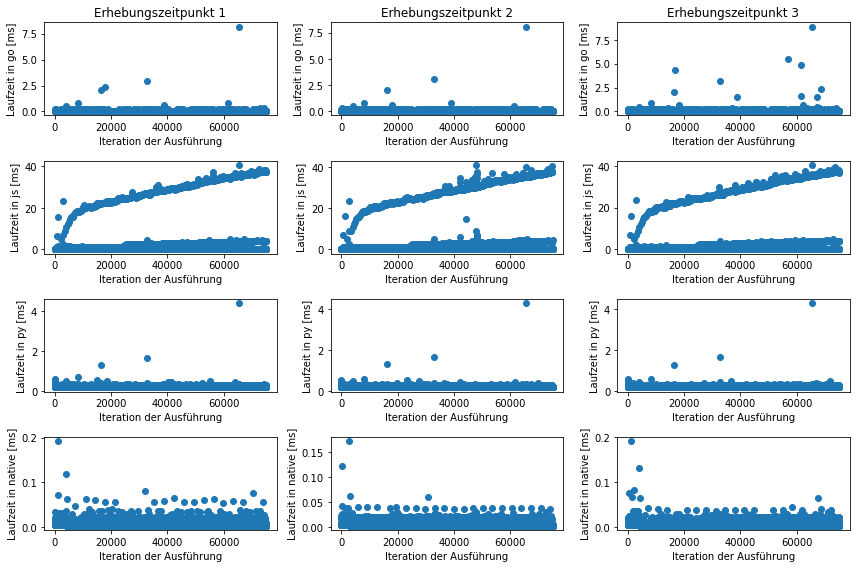

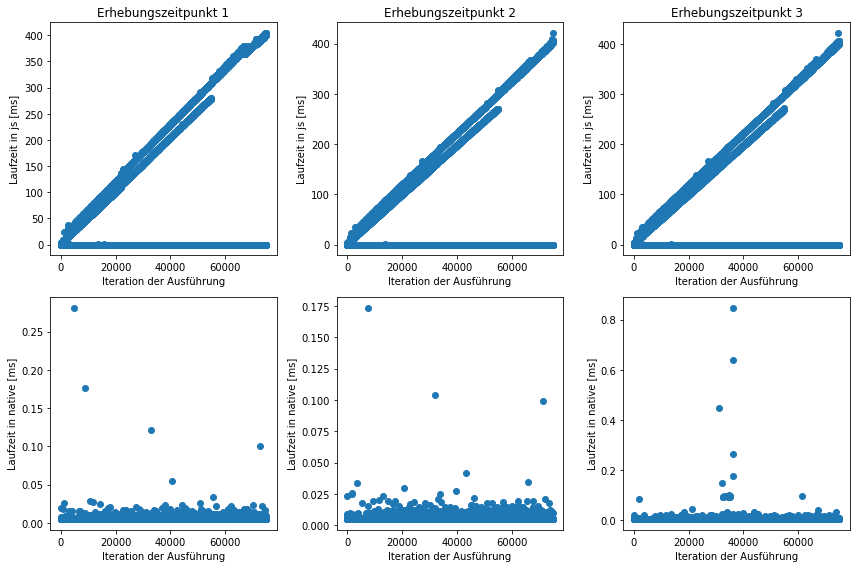

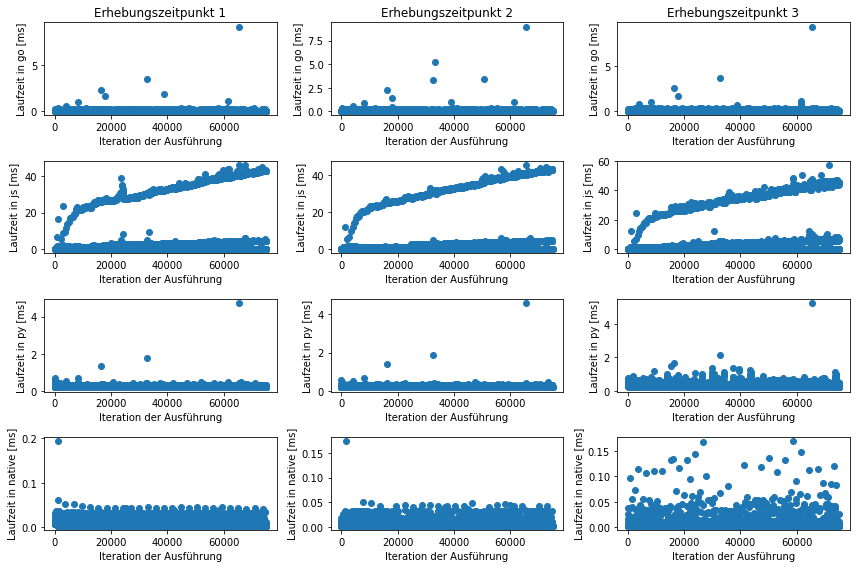

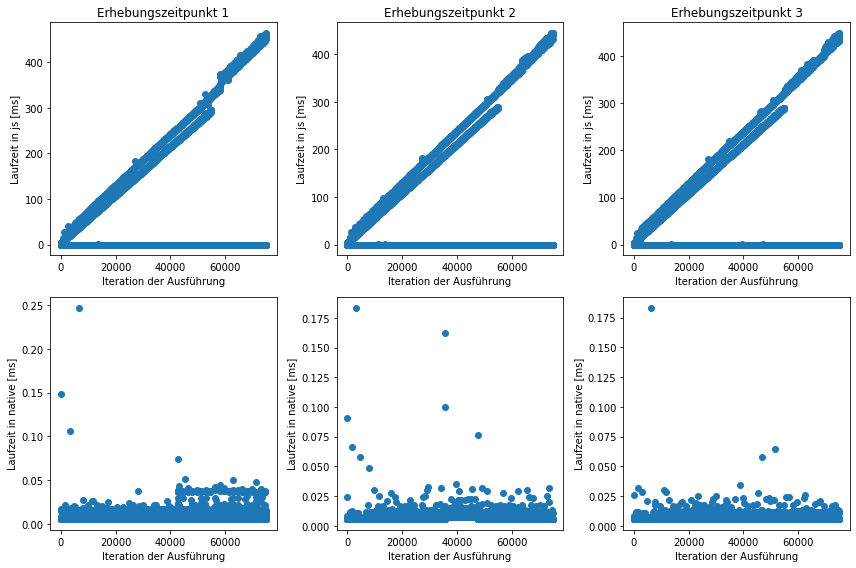

In [12]:
scatter(device='3b+', os='ubuntu64')
scatter(device='3b+', os='rpios32')
scatter(device='3b.', os='ubuntu64')
scatter(device='3b.', os='rpios32')

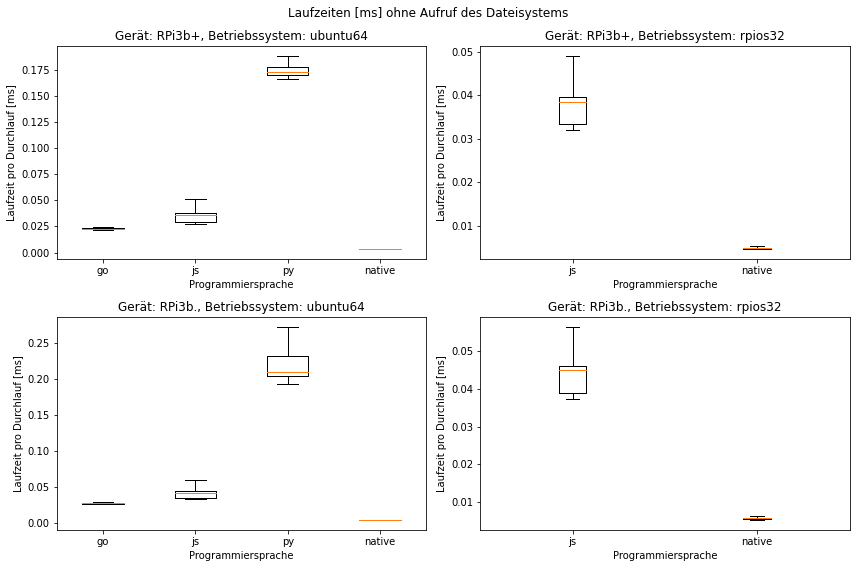

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for idx_device, device in enumerate(runtime_device_data.keys()):
    for idx_os, os in enumerate(runtime_device_data[device].keys()):
        runtimes_data = {}
        for idx_runtime, runtime in enumerate(runtime_device_data[device][os].keys()):
            runtimes_data[runtime] = runtime_device_data[device][os][runtime]['time (ns)']/1000000
        runtimes_data = pandas.DataFrame(runtimes_data)
        axes[idx_device, idx_os].set_facecolor('#FFFFFF')
        axes[idx_device, idx_os].boxplot(runtimes_data, showfliers=False)
        axes[idx_device, idx_os].set_title(f'Gerät: RPi{device}, Betriebssystem: {os}')
        axes[idx_device, idx_os].set_xticklabels(labels=runtimes_data.columns)
        axes[idx_device, idx_os].set_ylabel('Laufzeit pro Durchlauf [ms]')
        axes[idx_device, idx_os].set_xlabel('Programmiersprache')
fig.suptitle('Laufzeiten [ms] ohne Aufruf des Dateisystems')
fig.tight_layout()
fig.savefig('boxplots.png',facecolor='white')

## Data time means (ns)

In [10]:
def map_data(date_manipulation, data=runtime_device_data):
    temp_data = {}
    for device in data.keys():
        temp_data[device] = {}
        for os in data[device].keys():
            temp_data[device][os] = {}
            for runtime in data[device][os].keys():
                temp_data[device][os][runtime] = date_manipulation(data[device][os][runtime],device,os,runtime,data)
    return temp_data
def map_data_pure(date_manipulation, data=runtime_device_data):
    for device in data.keys():
        for os in data[device].keys():
            for runtime in data[device][os].keys():
                date_manipulation(data[device][os][runtime],device,os,runtime,data)

### Absolute means

In [11]:
time_field = 'time (ns)'
runtime_device_data_means = map_data(lambda date, device, os, runtime, all_data: date[time_field].mean())
pretty_print_data(runtime_device_data_means, 'ns')

3b+:
	ubuntu64:
		go: 24837.320404444443 ns
		js: 485506.15288444445 ns
		py: 176853.52916 ns
		native: 3276.062342222222 ns
	rpios32:
		js: 6697170.199257778 ns
		native: 4910.191755555556 ns
3b.:
	ubuntu64:
		go: 29147.46512888889 ns
		js: 568882.6907688889 ns
		py: 226886.67937777776 ns
		native: 3814.2573022222223 ns
	rpios32:
		js: 7238973.077724445 ns
		native: 5846.464862222222 ns


### Means relative to native

In [9]:
delta_means_rel = map_data(lambda date, device, os, runtime, all_data:date / all_data[device][os]['native'], runtime_device_data_means)
pretty_print_data(delta_means_rel)

3b+:
	ubuntu64:
		go: 107.073036355221 ns
		js: 193.22374288792278 ns
		py: 76.42176069140761 ns
		native: 1.0 ns
	rpios32:
		js: 481.3706074930751 ns
		native: 1.0 ns
3b.:
	ubuntu64:
		go: 103.39416259053934 ns
		js: 179.8032249806953 ns
		py: 71.77013258274827 ns
		native: 1.0 ns
	rpios32:
		js: 446.5785266978426 ns
		native: 1.0 ns


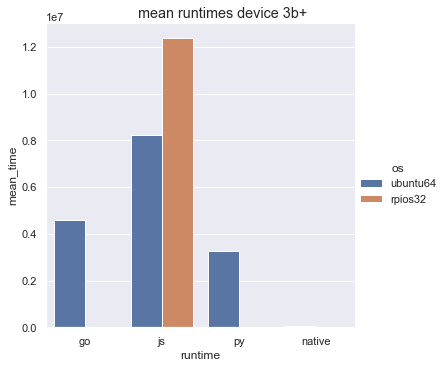

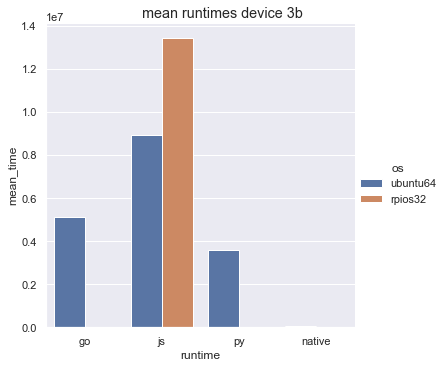

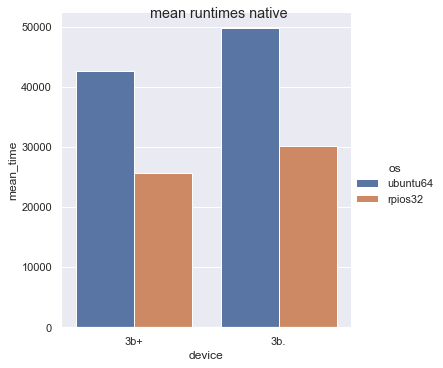

In [66]:
import seaborn as sns
data_list = []
map_data_pure(
    lambda date, device, os, runtime, all_data:
        data_list.append({'device': device, 'os': os, 'runtime': runtime, 'mean_time': date}), runtime_device_data_means)
data = pandas.DataFrame(data_list)
sns.set(rc={'figure.facecolor':'white'})

tmp = data[data['device'] == '3b+']
ax = sns.catplot(data = tmp, kind="bar", x="runtime", y="mean_time", hue="os")
ax.set(ylabel='mean time (ns)')
ax.fig.suptitle('mean runtimes device 3b+')
ax.savefig("mean_times_3b+.png")

tmp = data[data['device'] == '3b.']
ax = sns.catplot(data = tmp, kind="bar", x="runtime", y="mean_time", hue="os")
ax.set(ylabel='mean time (ns)')
ax.fig.suptitle('mean runtimes device 3b')
ax.savefig("mean_times_3b.png")

tmp = data.query("runtime=='native'")
ax = sns.catplot(data = tmp, kind="bar", x="device", y="mean_time", hue="os")
ax.set(ylabel='mean time (ns)')
ax.fig.suptitle('mean runtimes native')
ax.savefig("mean_times_native.png")

## Data time standard deviations (ns)

In [67]:
time_field = 'time (ns)'
runtime_device_data_stds = map_data(lambda date, device, os, runtime, all_data: date[time_field].std())
pretty_print_data(runtime_device_data_stds, 'ms')

3b+:
	ubuntu64:
		go: 2.524160953178403 ms
		js: 5.81342464970086 ms
		py: 1.4528913005266697 ms
		native: 0.014889705254302422 ms
	rpios32:
		js: 41.38579831069536 ms
		native: 0.03917422269880908 ms
3b.:
	ubuntu64:
		go: 2.845189445467819 ms
		js: 6.368635902409733 ms
		py: 1.5940647578133609 ms
		native: 0.0182328473309366 ms
	rpios32:
		js: 44.775194575832884 ms
		native: 0.044768709584698134 ms


In [68]:
# time.apply(lambda date: date/1000000).max()

,Gerät,Implementierung,Betriebssystem,Programmiersprache,mean time relative to native
0,Raspberry Pi 3b+,mit FS Aufruf,Ubuntu,go,107.07
1,Raspberry Pi 3b+,mit FS Aufruf,Ubuntu,js,193.22
2,Raspberry Pi 3b+,mit FS Aufruf,Ubuntu,python,76.42
3,Raspberry Pi 3b+,mit FS Aufruf,Raspbian,js,481.37
4,Raspberry Pi 3b+,ohne FS Aufruf,Ubuntu,go,7.58
5,Raspberry Pi 3b+,ohne FS Aufruf,Ubuntu,js,148.20
6,Raspberry Pi 3b+,ohne FS Aufruf,Ubuntu,python,53.98
7,Raspberry Pi 3b+,ohne FS Aufruf,Raspbian,js,1363.93
8,Raspberry Pi 3b,mit FS Aufruf,Ubuntu,go,103.39
9,Raspberry Pi 3b,mit FS Aufruf,Ubuntu,js,179.80


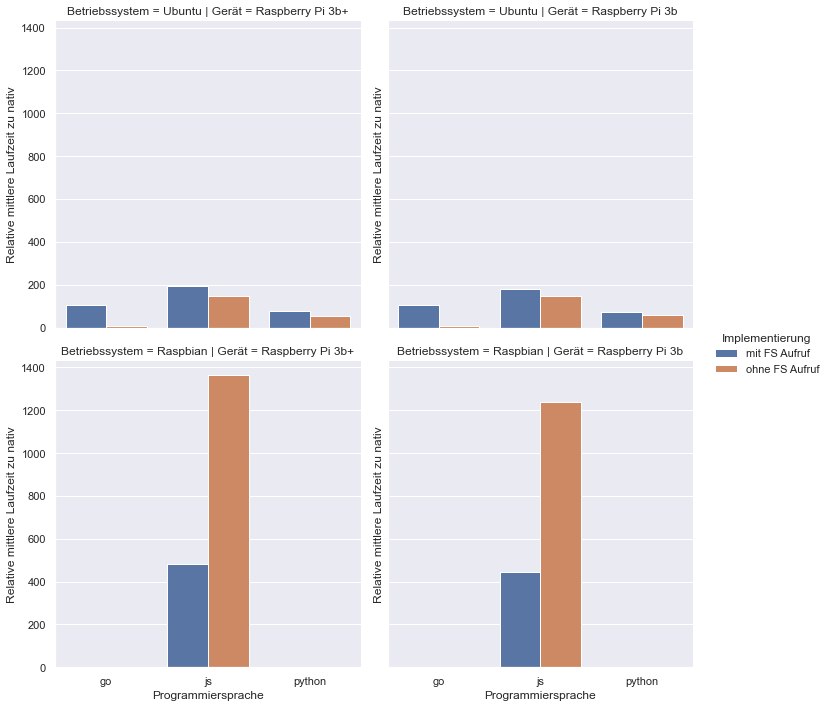

In [28]:
rel_means_data = [
    ['Raspberry Pi 3b+', 'mit FS Aufruf', 'Ubuntu', 'go', 107.07],
    ['Raspberry Pi 3b+', 'mit FS Aufruf', 'Ubuntu', 'js', 193.22],
    ['Raspberry Pi 3b+', 'mit FS Aufruf', 'Ubuntu', 'python', 76.42],
    ['Raspberry Pi 3b+', 'mit FS Aufruf', 'Raspbian', 'js', 481.37],
    ['Raspberry Pi 3b+', 'ohne FS Aufruf', 'Ubuntu', 'go', 7.58],
    ['Raspberry Pi 3b+', 'ohne FS Aufruf', 'Ubuntu', 'js', 148.20],
    ['Raspberry Pi 3b+', 'ohne FS Aufruf', 'Ubuntu', 'python', 53.98],
    ['Raspberry Pi 3b+', 'ohne FS Aufruf', 'Raspbian', 'js', 1363.93],
    ['Raspberry Pi 3b', 'mit FS Aufruf', 'Ubuntu', 'go', 103.39],
    ['Raspberry Pi 3b', 'mit FS Aufruf', 'Ubuntu', 'js', 179.80],
    ['Raspberry Pi 3b', 'mit FS Aufruf', 'Ubuntu', 'python', 71.77],
    ['Raspberry Pi 3b', 'mit FS Aufruf', 'Raspbian', 'js', 446.58],
    ['Raspberry Pi 3b', 'ohne FS Aufruf', 'Ubuntu', 'go', 7.64],
    ['Raspberry Pi 3b', 'ohne FS Aufruf', 'Ubuntu', 'js', 149.15],
    ['Raspberry Pi 3b', 'ohne FS Aufruf', 'Ubuntu', 'python', 59.48],
    ['Raspberry Pi 3b', 'ohne FS Aufruf', 'Raspbian', 'js', 1238.18],
]
rel_means = pandas.DataFrame(rel_means_data, columns=["Gerät", "Implementierung", "Betriebssystem", "Programmiersprache", "mean time relative to native"])
display(rel_means)

import seaborn as sns

data_list = []
sns.set(rc={'figure.facecolor':'white'})
tmp = rel_means
ax = sns.catplot(data = tmp, kind="bar", x="Programmiersprache", y="mean time relative to native", hue="Implementierung", col="Gerät", row="Betriebssystem")
ax.set(ylabel='Relative mittlere Laufzeit zu nativ')
ax.tight_layout()
ax.savefig("relative_mean_times.png", dpi=300)

,device,variant,os,runtime,mean time (ns)
0,Raspberry Pi 3b+,with fs sys-call,Ubuntu,go,4570250.48
1,Raspberry Pi 3b+,with fs sys-call,Ubuntu,js,8247462.98
2,Raspberry Pi 3b+,with fs sys-call,Ubuntu,python,3261947.17
3,Raspberry Pi 3b+,with fs sys-call,Ubuntu,native,42683.49
4,Raspberry Pi 3b+,with fs sys-call,Raspbian,js,12372149.22
5,Raspberry Pi 3b+,with fs sys-call,Raspbian,native,25701.92
6,Raspberry Pi 3b+,without fs sys-call,Ubuntu,go,24837.32
7,Raspberry Pi 3b+,without fs sys-call,Ubuntu,js,485506.15
8,Raspberry Pi 3b+,without fs sys-call,Ubuntu,python,176853.53
9,Raspberry Pi 3b+,without fs sys-call,Ubuntu,native,3276.06


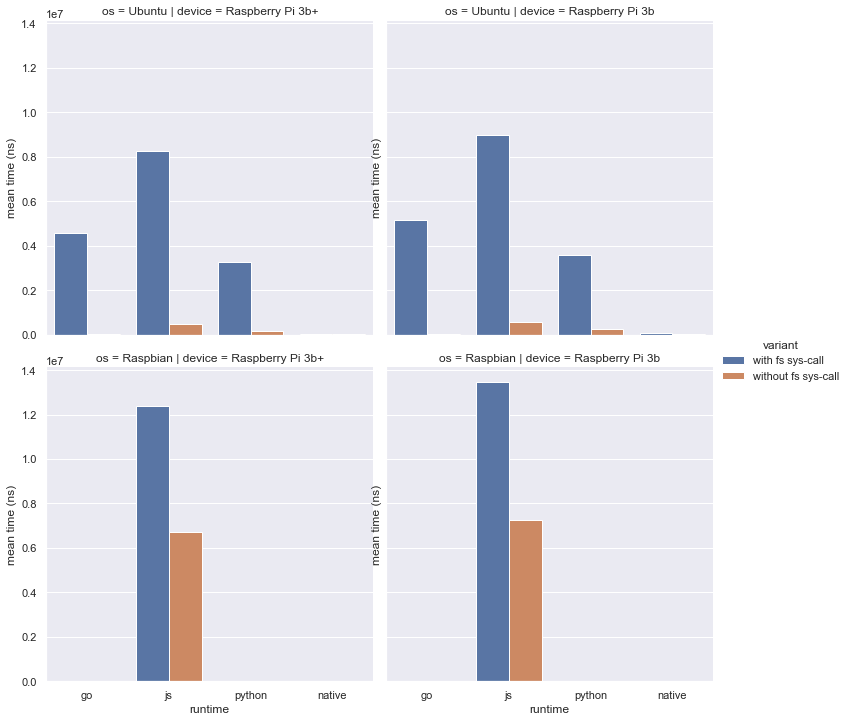

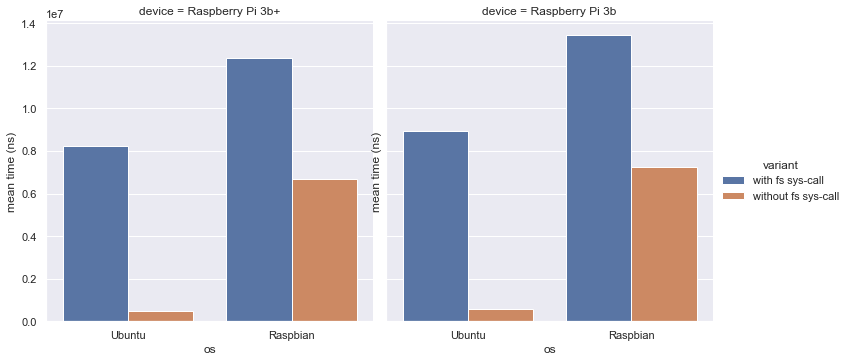

In [4]:
total_means_data = [
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Ubuntu', 'go', 4570250.48],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Ubuntu', 'js', 8247462.98],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Ubuntu', 'python', 3261947.17],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Ubuntu', 'native', 42683.49],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Raspbian', 'js', 12372149.22],
    ['Raspberry Pi 3b+', 'with fs sys-call', 'Raspbian', 'native', 25701.92],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Ubuntu', 'go', 24837.32],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Ubuntu', 'js', 485506.15],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Ubuntu', 'python', 176853.53],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Ubuntu', 'native', 3276.06],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Raspbian', 'js', 6697170.20],
    ['Raspberry Pi 3b+', 'without fs sys-call', 'Raspbian', 'native', 4910.19],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Ubuntu', 'go', 5151524.89],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Ubuntu', 'js', 8958540.47],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Ubuntu', 'python', 3575884.90],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Ubuntu', 'native', 49824.14],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Raspbian', 'js', 13443498.05],
    ['Raspberry Pi 3b', 'with fs sys-call', 'Raspbian', 'native', 30103.32],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Ubuntu', 'go', 29147.47],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Ubuntu', 'js', 568882.69],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Ubuntu', 'python', 226886.68],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Ubuntu', 'native', 3814.26],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Raspbian', 'js', 7238973.08],
    ['Raspberry Pi 3b', 'without fs sys-call', 'Raspbian', 'native', 5846.46],
]
total_means = pandas.DataFrame(total_means_data, columns=["device", "variant", "os", "runtime", "mean time (ns)"])
display(total_means)

import seaborn as sns

data_list = []
sns.set(rc={'figure.facecolor':'white'})
tmp = total_means
ax = sns.catplot(data = tmp, kind="bar", x="runtime", y="mean time (ns)", hue="variant", col="device", row="os")
ax.set(ylabel='mean time (ns)')
ax.savefig("mean_times.png")
tmp = total_means[total_means["runtime"]=="js"]
ax = sns.catplot(data = tmp, kind="bar", x="os", y="mean time (ns)", hue="variant", col="device")
ax.set(ylabel='mean time (ns)')
ax.savefig("mean_times_native.png")